# Potential flow around a cylinder

2D flow in a plane around a cylinder. Full setup for the problem is nicely explained here: https://en.wikipedia.org/wiki/Potential_flow_around_a_circular_cylinder

Mathematical derivation for the exact solution can be found here: https://courses.seas.harvard.edu/climate/eli/Courses/APM105/Sources/08-PDEs/03-Laplace/notes-potential-flow-around-cylinder.pdf

The exact solution is usually calculated using polar coordinates.
We make a few assumptions:
- The flow has no vorticity and the liquid is assumed to be incompressible ($\nabla^2\phi = 0$).
- Far away from the cylinder, the flow is uniform with magnitude U.
- The cylinder has radius R.

We will skip straight to the solution, which is governed by the following equation. The equation is phrased in terms of the
velocity potential $\phi$, which can differentiated to find the Velocity components in the $r$ and $\theta$ directions. I have copied the below code for the analytical solution from: http://flothesof.github.io/2D-potential-flow-finite-differences.html


$$\phi (r,\theta )=Ur\left(1+{\frac {R^{2}}{r^{2}}}\right)\cos \theta \,.$$
$$V_{r}={\frac {\partial \phi }{\partial r}}=U\left(1-{\frac {R^{2}}{r^{2}}}\right)\cos \theta $$
$$ V_{\theta }={\frac {1}{r}}{\frac {\partial \phi }{\partial \theta }}=-U\left(1+{\frac {R^{2}}{r^{2}}}\right)\sin \theta \,.$$

The PDE which we are trying to solve is Laplace's equation ($\nabla^2\phi = 0$). In polar coordinates, $\nabla^2\phi$ is equal to:

$$
\nabla^2\phi = \frac{\partial^2\phi}{\partial r^2} + \frac{1}{r}\frac{\partial \phi}{\partial r} + \frac{1}{r^2}\frac{\partial^2 \phi}{\partial\theta^2} = 0
$$
In Cartesian 2D coordinates, $\nabla^2\phi$ is equal to:
$$
\nabla^2\phi = \frac{\partial^2\phi}{\partial x^2}  + \frac{\partial^2 \phi}{\partial y^2} = 0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from cylinder_channel_geometry import *
from cylinder_channel_exact_solutions import *
from torch.optim.lr_scheduler import StepLR

# Geometry

In [2]:
# Set geometric parameters.

# Grid
grid_length_x = 10
grid_length_y = 5
grid_nr_xs = 100
grid_nr_ys = 50

# Cylinder
cylinder_radius = 1
cylinder_center = (0, 0)
nr_samples_on_cylinder = 100

make_plots = False


In [3]:
# Get grid.
grid = make_grid(
    x_length=grid_length_x,
    y_length=grid_length_y,
    nr_xs=grid_nr_xs,
    nr_ys=grid_nr_ys,
    make_plot=make_plots
)

In [4]:
# Get grid xs and ys.
xs, ys = grid

In [5]:
# Sample channel boundary.
inlet_xys, outlet_xys, left_wall_xys, right_wall_xys = sample_channel_boundary(grid, make_plots)

In [6]:
# Sample grid without cylinder.
channel_with_cylinder_xs, channel_with_cylinder_ys = exclude_cylinder_points(grid, make_plot=make_plots)

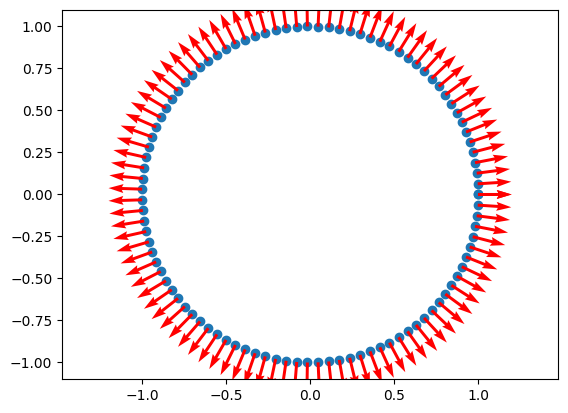

In [7]:
# Sample cylinder boundary.
cylinder_boundary_xs, cylinder_boundary_ys, cylinder_normals = sample_cylinder_boundary_and_compute_normals(
    cylinder_center,
    cylinder_radius,
    nr_samples_on_cylinder,
    True
)

In [8]:
# # Plot grid without cylinder, cylinder boundary, and cylinder normals.
# plt.figure(figsize=(20,10))
# plt.scatter(channel_with_cylinder_xs, channel_with_cylinder_ys)
# plt.scatter(cylinder_boundary_xs, cylinder_boundary_ys)
# # plt.quiver(cylinder_boundary_xs, cylinder_boundary_ys, -cylinder_normals[:, 0], -cylinder_normals[:, 1], color='red', scale=5, scale_units='xy', angles='xy', label='Normal Vectors')
# plt.show()

# Get training data / compute exact solution

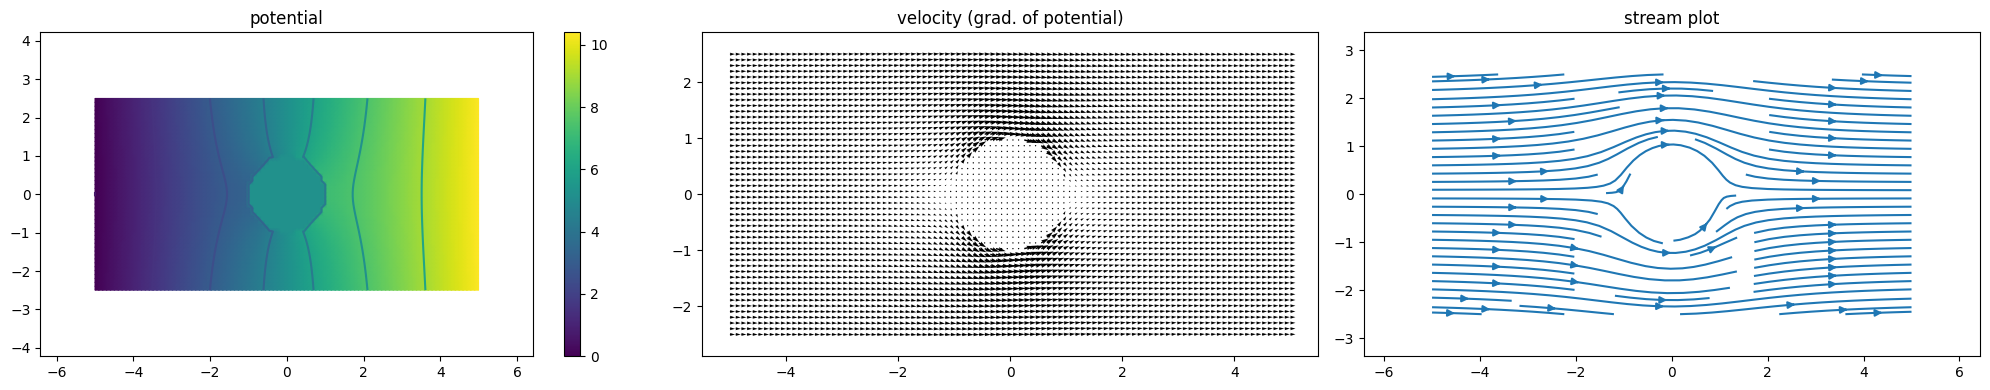

In [9]:
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution(grid, U=1, R=cylinder_radius)

make_plot(phi_exact, grid, uv=(v_x_exact, v_y_exact))

# PINN architecture.

In [10]:
# define network architecture

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )

    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x

# Training

In [11]:
# Prepare grid points for training.
grid_points_xs = channel_with_cylinder_xs.compressed()
grid_points_ys = channel_with_cylinder_ys.compressed()

grid_points_xys = np.zeros((grid_points_xs.shape[0], 2))
grid_points_xys[:, 0] = grid_points_xs
grid_points_xys[:, 1] = grid_points_ys

cylinder_boundary_xys = np.zeros((cylinder_boundary_xs.shape[0], 2))
cylinder_boundary_xys[:, 0] = cylinder_boundary_xs
cylinder_boundary_xys[:, 1] = cylinder_boundary_ys

physics_xys = np.vstack((grid_points_xys, cylinder_boundary_xys))

# Extract indices of boundary.
inlet_indices = np.where(physics_xys[:, 0] == -grid_length_x/2)
outlet_indices = np.where(physics_xys[:, 0] == grid_length_x/2)
left_wall_indices = np.where(physics_xys[:, 1] == grid_length_y/2)
right_wall_indices = np.where(physics_xys[:, 1] == -grid_length_y/2)

physics_xys = torch.tensor(physics_xys, dtype=torch.float32).requires_grad_(True)

In [18]:
normals_tensor = torch.tensor(-cylinder_normals, dtype=torch.float32)

In [19]:
# Move all to GPU if available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

physics_xys = physics_xys.to(device)

normals_tensor = normals_tensor.to(device)


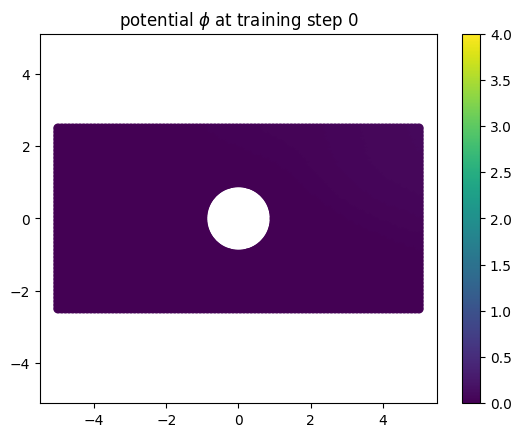

tensor(10.9325, device='cuda:0', grad_fn=<AddBackward0>)


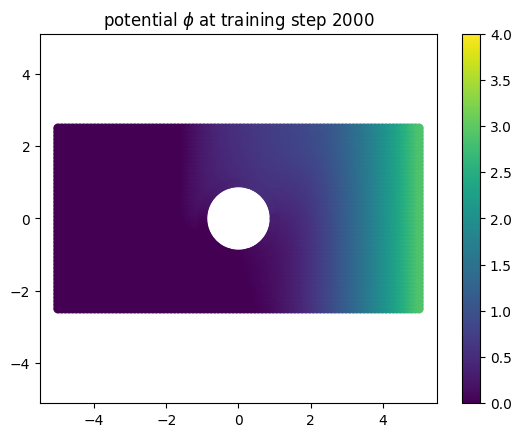

tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)


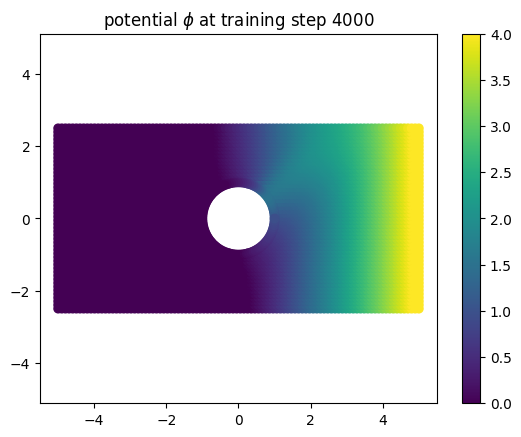

tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>)


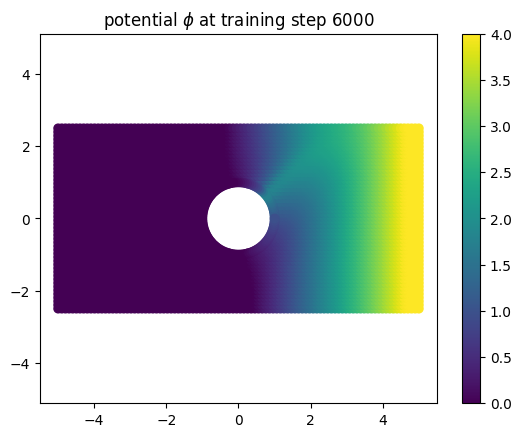

tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)


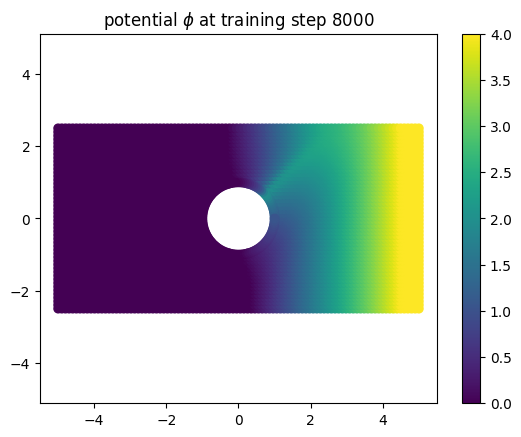

tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)


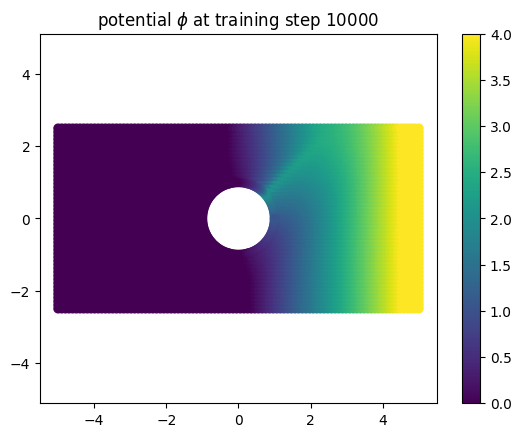

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


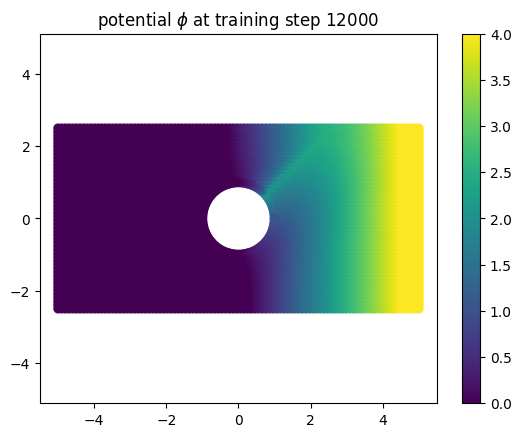

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


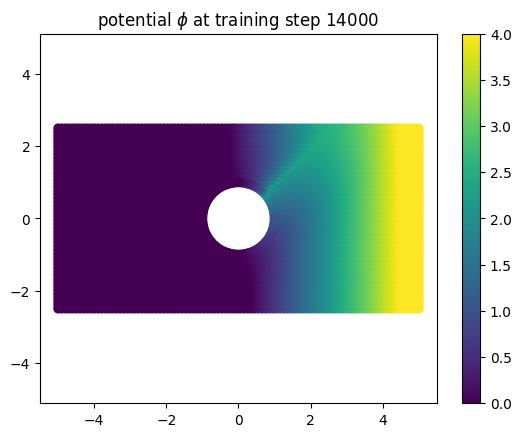

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


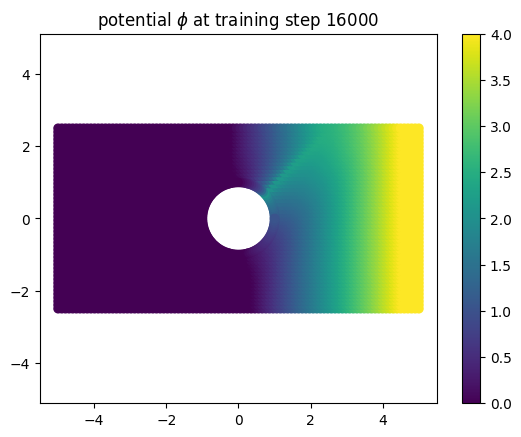

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


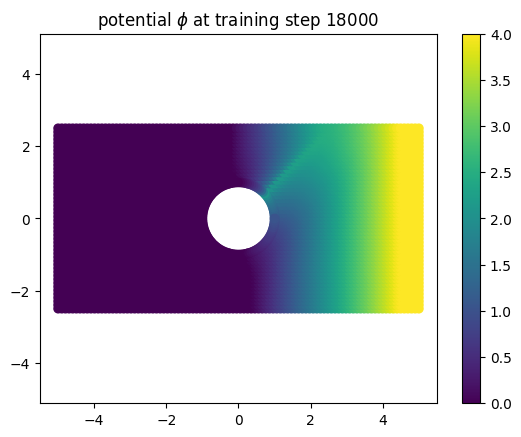

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


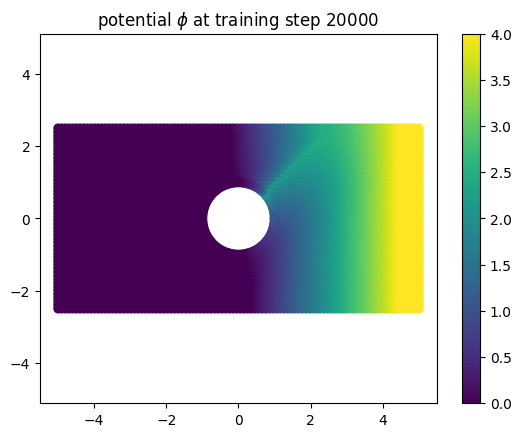

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


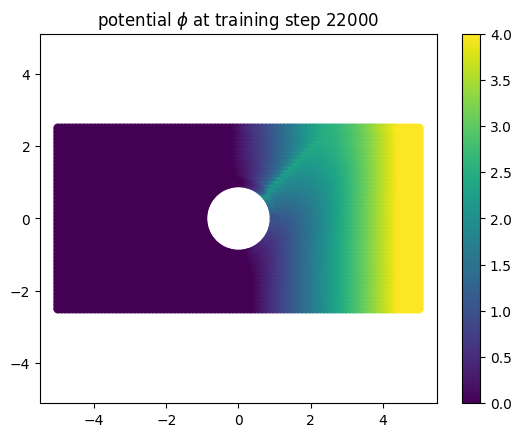

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


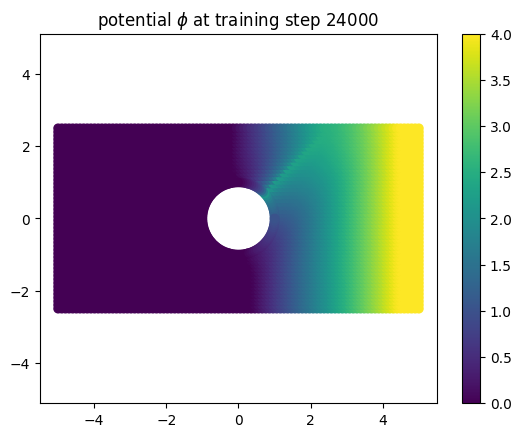

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


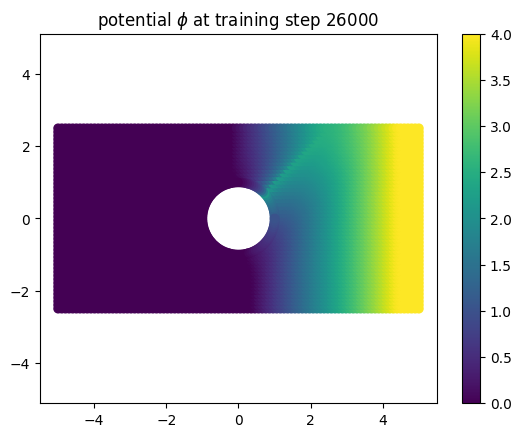

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


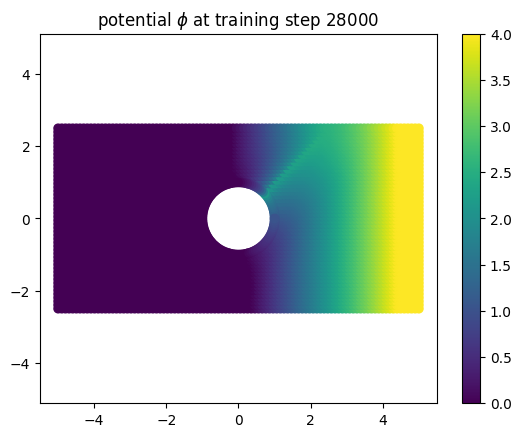

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


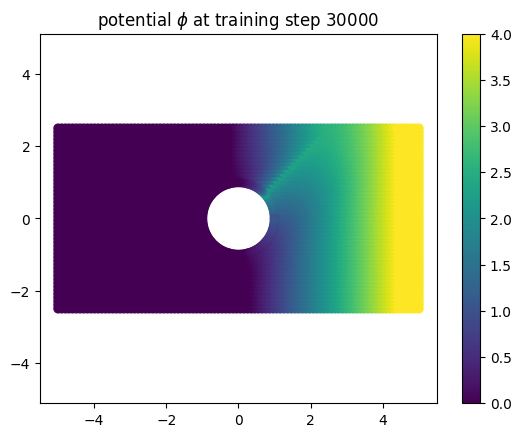

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


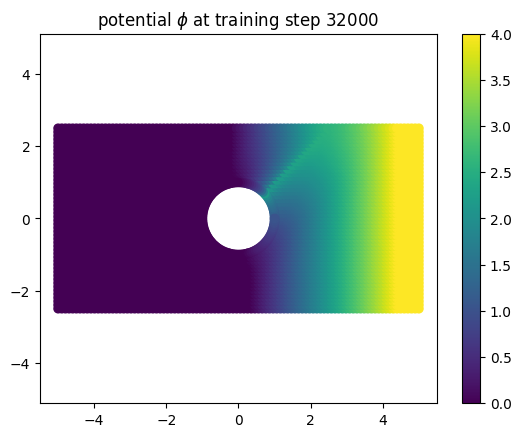

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


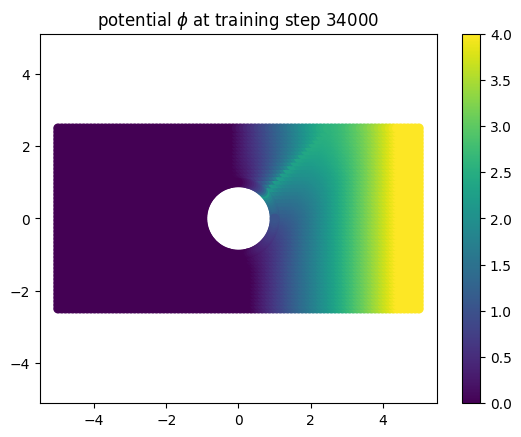

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


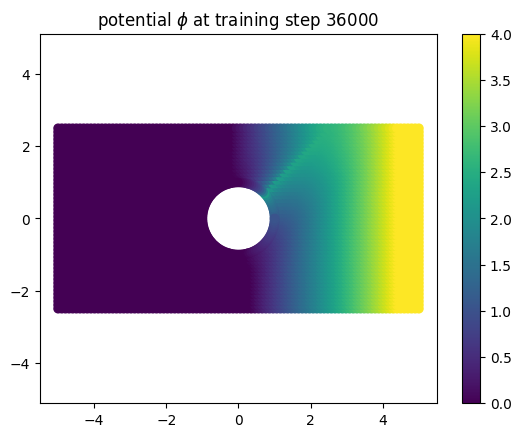

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


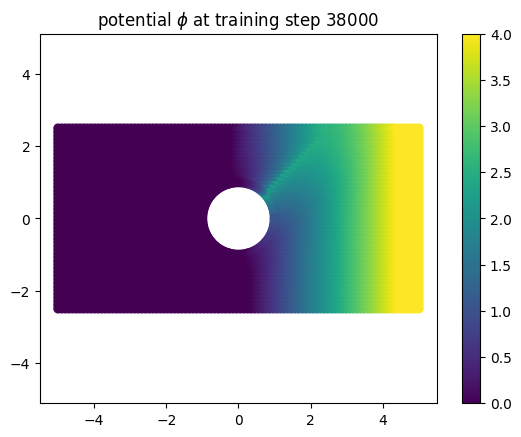

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


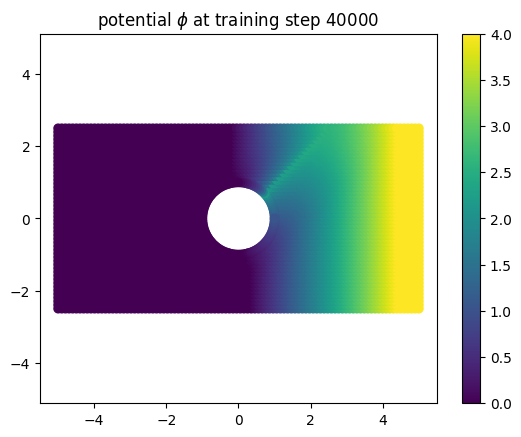

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


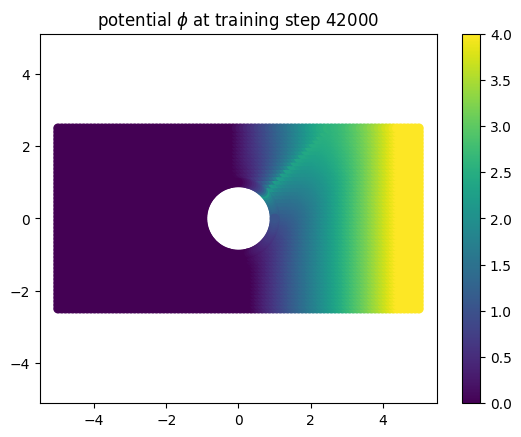

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


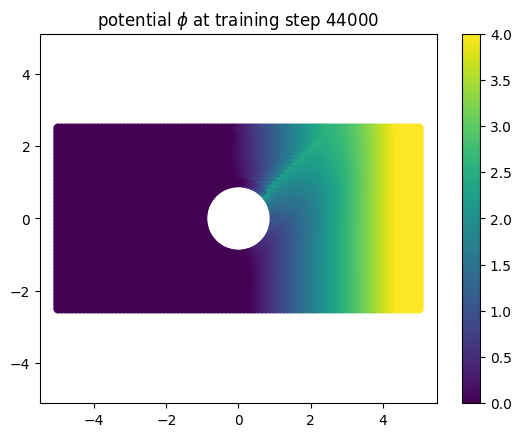

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


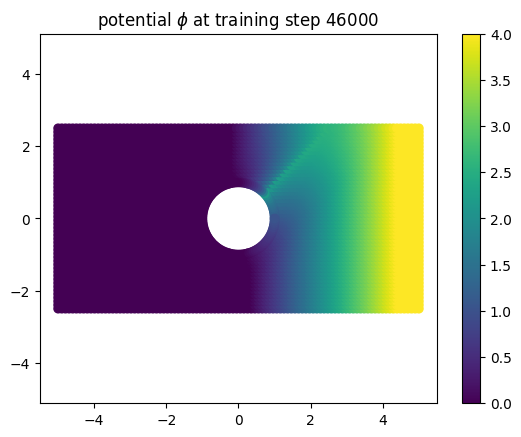

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


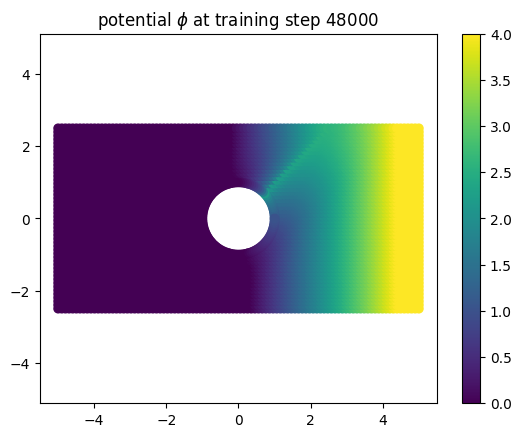

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


In [20]:

# Define the architecture.
pinn = FullyConnected(2, 64, 1)
pinn.to(device)

# Set optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

nr_steps = 50000

inlet_velocity_x = 1.0
inlet_velocity_y = 0.0

outlet_velocity_x = 1.0
outlet_velocity_y = 0.0

lambda_in = 1
lambda_out = 10
lambda_pde = 1
lambda_walls = 1
lambda_cylinder = 1

torch.manual_seed(123)

# Training loop.
for i in range(nr_steps):
    optimizer.zero_grad()

    

    # Get model predictions.
    pinn_pred = pinn(physics_xys)

    grad_f = torch.autograd.grad(
        pinn_pred,
        physics_xys,
        grad_outputs=torch.ones_like(pinn_pred),
        create_graph=True,
    )[0]

    # Inlet constraint.
    inlet_grad = grad_f[inlet_indices]

    inlet_velocity_loss = torch.mean((inlet_grad[:, 0] - inlet_velocity_x) ** 2) + torch.mean((inlet_grad[:, 1] - inlet_velocity_y)**2 )

    # Outlet constraint.
    outlet_grad = grad_f[outlet_indices]

    outlet_velocity_loss = torch.mean((outlet_grad[:, 0] - outlet_velocity_x) ** 2) + torch.mean((outlet_grad[:, 1] - outlet_velocity_y)**2 )

    # Channel walls constraints. No flux.
    left_wall_grad = grad_f[left_wall_indices]
    left_wall_loss = torch.mean(left_wall_grad[:, 1]**2)  # Normal direction is (0, 1).

    right_wall_grad = grad_f[right_wall_indices]
    right_wall_flux = -right_wall_grad[:, 1]  # Normal direction is (0,-1).
    right_wall_loss = torch.mean(right_wall_flux**2)

    # Cylinder boundary constraint.
    cylinder_dx = grad_f[-cylinder_boundary_xs.shape[0]:, 0]
    cylinder_dy = grad_f[-cylinder_boundary_xs.shape[0]:, 1]

    cylinder_flux = (cylinder_dx * normals_tensor[:, 0] + cylinder_dy * normals_tensor[:, 1])

    cylinder_flux_loss = torch.mean(cylinder_flux**2)

    # Compute second order derivative.
    nabla_f = torch.autograd.grad(grad_f, physics_xys, grad_outputs=torch.ones_like(grad_f), create_graph=True)[0]

    # PDE constraint. Laplace.
    residual = torch.sum(nabla_f, 1)
    pde_loss = torch.mean(residual**2)

    loss = (
        lambda_in*inlet_velocity_loss
        + lambda_out*outlet_velocity_loss
        + lambda_walls*right_wall_loss
        + lambda_walls*left_wall_loss
        + lambda_cylinder*cylinder_flux_loss
        + lambda_pde*pde_loss
    )

    loss.backward()
    optimizer.step()
    scheduler.step()

    if i % 2000 == 0:
        phi = pinn(physics_xys).detach().cpu()
        xys = physics_xys.detach().cpu().numpy()

        fig, ax = plt.subplots()
        m = ax.scatter(xys[:, 0], xys[:, 1], c=phi, vmin=0, vmax=4)
        cbar = plt.colorbar(m, ax=ax)
        ax.axis("equal")
        ax.set_title(f"potential $\phi$ at training step {i}")
        plt.show()
        print(loss)

In [ ]:
torch.manual_seed(123)

# Define the architecture.
pinn = FullyConnected(2, 264, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(-5.5, 5.5, 20).requires_grad_(True)
y_physics = torch.linspace(-2, 2, 20).requires_grad_(True)
grid_x_physics, grid_y_physics = torch.meshgrid(x_physics, y_physics, indexing='ij')
grid_xy_physics = torch.stack((grid_x_physics.ravel(), grid_y_physics.ravel()))
grid_xy_physics = torch.transpose(grid_xy_physics, 0, 1)
print(grid_xy_physics.size())

# define data over the domain
x_data = torch.linspace(-7.5, 7.5, 30)
y_data = torch.linspace(-2.5, 2.5, 10)
grid_x_data, grid_y_data = torch.meshgrid(x_data, y_data, indexing='ij')

xy_data2 = torch.stack((grid_x_data.ravel(), grid_y_data.ravel()))
xy_data_final = torch.transpose(xy_data2, 0, 1)


# get analytical solution for defined data points
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution((grid_x_data, grid_y_data), U=1, R=0.5)
plt.plot(phi_exact.ravel())
plt.show()

optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-2)
us = []
for i in range(15001):
    optimiser.zero_grad()

    # compute physics loss
    phi_pred = pinn(grid_xy_physics)
    grad_f = torch.autograd.grad(phi_pred, grid_xy_physics, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]
    nabla_f = torch.autograd.grad(grad_f, grid_xy_physics, grad_outputs=torch.ones_like(grad_f), create_graph=True)[0]

    residual = torch.sum(nabla_f, 1)
    physics_loss = torch.mean(residual ** 2)

    # compute data loss
    phi_pred = pinn(xy_data_final)
    data_loss = torch.mean((phi_pred - phi_exact.ravel()) ** 2)

    # boundary loss
    """ TO BE INSERTED
    # No flux on walls.
    left_wall_pinn = pinn(left_wall_xys)
    right_wall_pinn = pinn(right_wall_xys)

    right_wall_grad = 0
     """

    # cylinder normal b.c.
    """
    grid_xy_cylinder = torch.from_numpy(cylinder_xys)
    print(grid_xy_cylinder)
    phi_pred_cylinder = pinn(grid_xy_cylinder)

    print("done")
    grad_f_cylinder = torch.autograd.grad(phi_pred_cylinder, cylinder_xys, grad_outputs=torch.ones_like(phi_pred_cylinder), create_graph=True)[0]
    nabla_f_cylinder = torch.autograd.grad(grad_f_cylinder, cylinder_xys, grad_outputs=torch.ones_like(grad_f_cylinder), create_graph=True)[0]
    residual_cylinder = torch.sum(nabla_f_cylinder, 1)
    cylinder_loss = torch.mean(residual_cylinder ** 2)
    """

    # backpropagate joint loss, take optimiser step
    lambda1 = 1 #1e-4
    # lambda1 = 1e-4
    loss = lambda1 * data_loss + physics_loss # + cylinder_loss
    loss.backward()
    optimiser.step()

    # record U value
    #us.append(U.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        phi = pinn(xy_data_final).detach()
        plt.plot(phi)
        plt.show()

        fig, ax = plt.subplots()

        phi = torch.reshape(phi, (30, 10))

        m = ax.pcolormesh(x_data, y_data, np.swapaxes(phi,0,1), shading='Gouraud', vmin=-1, vmax=16)
        #ax.contour(x_data, y_data, phi)
        plt.colorbar(m, ax=ax)
        ax.axis('equal')
        ax.set_title(f"potential at training step {i}")

        plt.show()

